In [ ]:
# %pip install pandas 
# %pip install matplotlib 
# %pip install seaborn
# %pip install statsmodels
# %pip install pmdarima 

In [12]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import joblib

In [3]:
filename = 'table_values_csv.csv'
df = pd.read_csv(filename, sep=',',low_memory=False)
display(df.head())

,id_x,due_date,new_due_date,created_at,updated_at,number,value,nfe_number,nfe_series,kind_x,...,document_number,authorized_third_party_id,company_name,kind_y,paymaster_id,ballast_kind,invoice_number,payment_place,update_reason_kind,finished_at
0,b13369ca-e3de-451c-bfa0-2c2c06db00da,2023-08-05,2023-08-05,2023-07-12 13:38:12.047933,2023-07-12 13:38:12.061655,003123,0.01,523451,6,services,...,1.394248e+13,NaN,"Ramalho, Macieira e Caldeira",registration_participant,NaN,invoice,123123,São Paulo,others,NaN
1,c2f7a256-7165-4787-966e-e094344827d8,2024-03-23,2024-03-23,2024-02-07 19:34:32.485735,2024-02-07 19:34:32.485735,2,2014.09,000005010,001,goods,...,1.394248e+13,NaN,"Ramalho, Macieira e Caldeira",registration_participant,NaN,nfe_key,NaN,BA,others,NaN
2,1bedeb72-2413-43ec-95a9-c6b539ce6a99,2024-01-17,2024-01-17,2023-12-20 13:22:01.374323,2023-12-20 13:22:01.374323,1,1047.74,000038412,001,goods,...,9.153087e+13,NaN,Gabeira-Mangueira,registration_participant,NaN,nfe_key,NaN,RN,NaN,NaN
3,ac2d5831-fdd6-44c5-8b07-01faa04dc451,2023-07-31,2023-07-31,2023-06-29 17:54:29.988490,2023-06-29 17:54:29.988490,3932,59.83,3932,1,goods,...,9.409448e+13,NaN,Cardoso LTDA,registration_participant,NaN,nfe_key,NaN,teste,operational_error,NaN
4,dacc7c5a-accb-430b-8d51-5aceb572e2c4,2033-08-05,2033-08-05,2024-02-07 18:56:32.251144,2024-02-07 18:56:32.256128,910304872,0.01,910304872,910304872,goods,...,1.394248e+13,NaN,"Ramalho, Macieira e Caldeira",registration_participant,NaN,nfe_key,NaN,São Paulo,others,NaN


In [38]:
# Converte a coluna para o tipo datetime, caso não esteja
df['created_at'] = pd.to_datetime(df['created_at'])

# Extrai o mês da coluna de datas
df['mes_referencia'] = df['created_at'].dt.month
df['dia_do_mes'] = df['created_at'].dt.day

# Criando uma coluna para categorizar os registros em "antes do dia 15" e "após o dia 15"
df['periodo_mes'] = df['dia_do_mes'].apply(lambda x: 'antes_15' if x <= 15 else 'apos_15')

display(df[['mes_referencia','dia_do_mes', 'periodo_mes' ]])

,mes_referencia,dia_do_mes,periodo_mes
0,7,12,antes_15
1,2,7,antes_15
2,12,20,apos_15
3,6,29,apos_15
4,2,7,antes_15
...,...,...,...
181234,6,7,antes_15
181235,6,7,antes_15
181236,6,7,antes_15
181237,6,7,antes_15


In [89]:
# Agora podemos agrupar por mês e período (antes ou após o dia 15) e contar os registros (total_registros)
df_mensal = df.groupby(['mes_referencia', 'periodo_mes']).agg(
    total_registros=('id_x', 'size')
).reset_index()

# Aplicando a transformação para a coluna mes_referencia
df_mensal['mes_referencia_ajustado'] = df_mensal.apply(
    lambda row: row['mes_referencia'] - 0.5 if row['periodo_mes'] == 'antes_15' else row['mes_referencia'], axis=1)

df_mensal = df_mensal[['mes_referencia_ajustado','total_registros' ]]

df_mensal = df_mensal.rename(columns={'mes_referencia_ajustado': 'mes_referencia'})

display(df_mensal)

,mes_referencia,total_registros
0,0.5,2862
1,1.0,346
2,1.5,5018
3,2.0,20985
4,2.5,6968
5,3.0,107739
6,3.5,3942
7,4.0,8308
8,4.5,4538
9,5.0,135


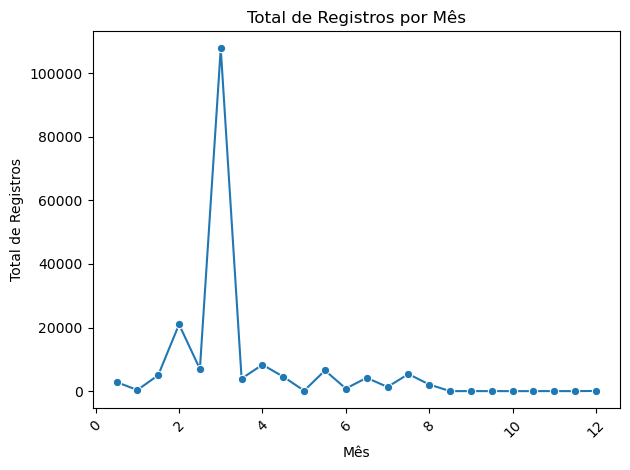

In [57]:
# Gráfico de Linhas
sns.lineplot(data=df_mensal, x='mes_referencia', y='total_registros', marker='o')
plt.title('Total de Registros por Mês')
plt.xlabel('Mês')
plt.ylabel('Total de Registros')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

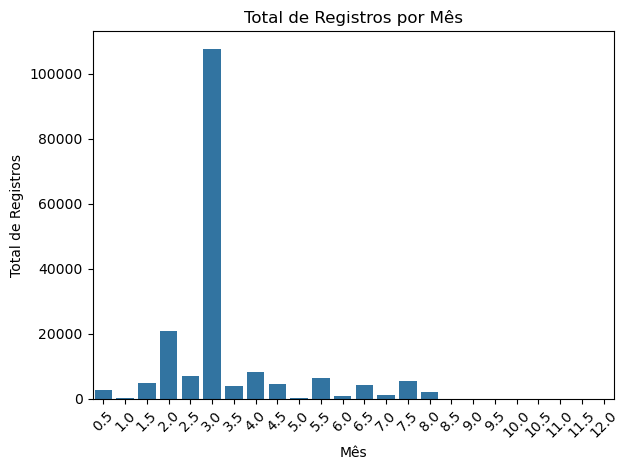

In [58]:
#Gráfico de Barras
sns.barplot(data=df_mensal, x='mes_referencia', y='total_registros', errorbar=None)
plt.title('Total de Registros por Mês')
plt.xlabel('Mês')
plt.ylabel('Total de Registros')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [90]:
#Removendo os meses que não tem incidencia de dados ( 9,10,11,12)
df_mensal = df_mensal[~df_mensal['mes_referencia'].isin([8.5, 9, 9.5, 10, 10.5, 11, 11.5, 12])]
display(df_mensal)

,mes_referencia,total_registros
0,0.5,2862
1,1.0,346
2,1.5,5018
3,2.0,20985
4,2.5,6968
5,3.0,107739
6,3.5,3942
7,4.0,8308
8,4.5,4538
9,5.0,135


In [91]:
# # Ajustar um modelo ARIMA com hiperparâmetros específicos
# model = auto_arima(df_mensal, start_p=0, start_q=0, start_order=0, max_p=10 ,max_q=10, max_order=10, test='adf', stepwise=False, trace=True, seasonal=False)

# Ajustando o modelo ARIMA com auto_arima
model = auto_arima(df_mensal['total_registros'], 
                   start_p=0, start_q=0, 
                   max_p=10, max_q=10, max_order=10, 
                   test='adf', 
                   stepwise=True, 
                   trace=True, 
                   seasonal=False)

# Resumo do modelo ajustado
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=356.055, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=346.957, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=344.314, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=354.185, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=340.147, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=341.461, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=344.629, Time=0.01 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=338.295, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=342.300, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=344.957, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=339.694, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.07 se

In [92]:
# Escolher a ordem do modelo (p,d,q) - Ex: (1,1,0))
modelo = ARIMA(df_mensal['total_registros'], order=(1,1,0))
model_fit = modelo.fit()

In [93]:
#Previsão do proximo mes
forecast = model_fit.forecast(steps=2)
future_month = [8.5, 9, 9.5]
forecast_df = pd.DataFrame({'mes_referencia': future_month, 'predicted_population': forecast})
forecast_df.set_index('mes_referencia', inplace=True)

forecast_df = forecast_df.astype(int)
display(forecast_df)

,predicted_population
mes_referencia,
8.5,4159
9.0,3136
9.5,3897


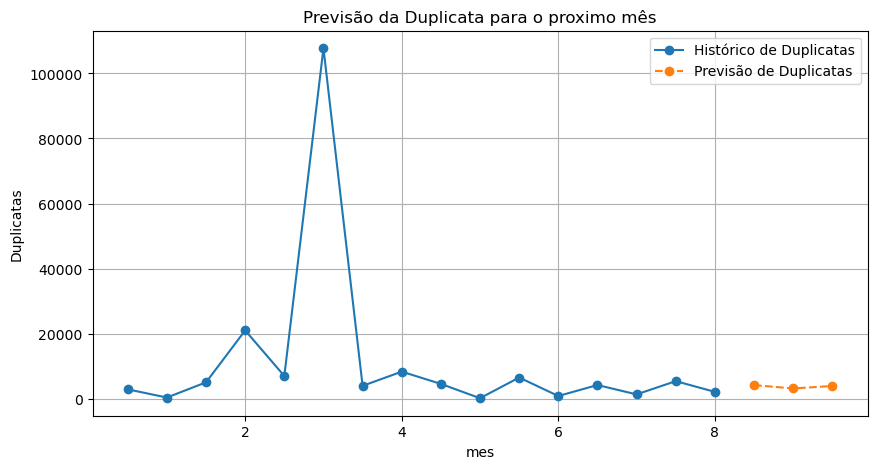

In [63]:
# Visualização dos Resultados
plt.figure(figsize=(10, 5))
plt.plot(df_mensal.set_index('mes_referencia'), label='Histórico de Duplicatas', marker='o')
plt.plot(forecast_df, label='Previsão de Duplicatas', linestyle='--', marker='o')
plt.xlabel('mes')
plt.ylabel('Duplicatas')
plt.title('Previsão da Duplicata para o proximo mês')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#Testar com tempos anteriores

In [94]:
#Removendo os meses para teste
df_mensal_teste = df_mensal[~df_mensal['mes_referencia'].isin([6.5, 7, 7.5, 8])]
display(df_mensal_teste)
display(df_mensal)

,mes_referencia,total_registros
0,0.5,2862
1,1.0,346
2,1.5,5018
3,2.0,20985
4,2.5,6968
5,3.0,107739
6,3.5,3942
7,4.0,8308
8,4.5,4538
9,5.0,135


,mes_referencia,total_registros
0,0.5,2862
1,1.0,346
2,1.5,5018
3,2.0,20985
4,2.5,6968
5,3.0,107739
6,3.5,3942
7,4.0,8308
8,4.5,4538
9,5.0,135


In [111]:
# Escolher a ordem do modelo (p,d,q) - Ex: (1,1,0)
modelo = ARIMA(df_mensal_teste['total_registros'], order=(1,1,0))
model_fit = modelo.fit()

#Previsão do proximo mes
forecast = model_fit.forecast(steps=2)
forecast_df = pd.DataFrame({'predicted_population': forecast})
forecast_df.set_index('mes_referencia', inplace=True)

forecast_df = forecast_df.astype(int)
display(forecast_df)

,predicted_population
mes_referencia,
6.5,4135
7.0,2199
7.5,3329
8.0,2669


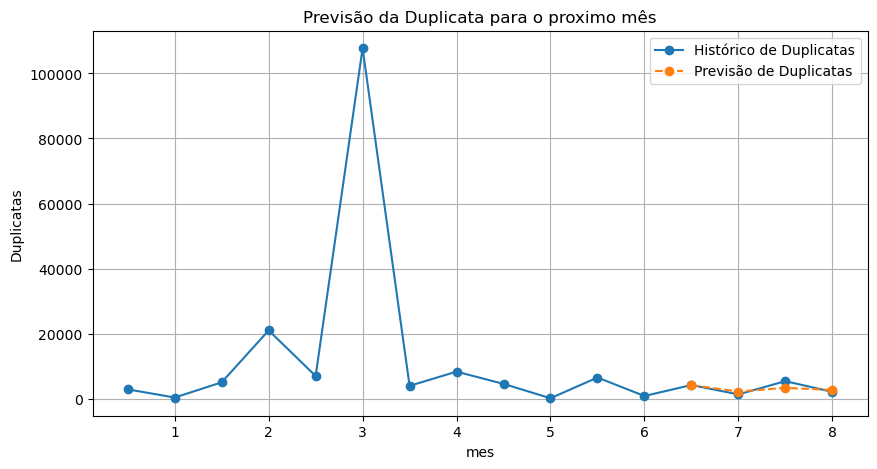

In [112]:
# Visualização dos Resultados
plt.figure(figsize=(10, 5))
plt.plot(df_mensal.set_index('mes_referencia'), label='Histórico de Duplicatas', marker='o')
plt.plot(forecast_df, label='Previsão de Duplicatas', linestyle='--', marker='o')
plt.xlabel('mes')
plt.ylabel('Duplicatas')
plt.title('Previsão da Duplicata para o proximo mês')
plt.legend()
plt.grid()
plt.show()